# MOS Spectroscopy of Extragalactic Field

**Use case:** emission-line measurements and template matching on 1D spectra.<br>
**Data:** [LEGA-C](https://www2.mpia-hd.mpg.de/home/legac/) spectra and galaxy template spectra; optical rest-frame.<br>
**Tools:**  specutils, astropy, matplotlib, pandas.<br>
**Cross-intrument:** NIRSpec <br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>

## Introduction

This notebook will perform a seris of spectroscopic analyses on multiple spectra, including smoothing, continuum fitting and subtraction, line identification, centroiding and flux measurements, gaussian fitting, equivalent widths, and template fitting.


**Note:** This notebook is intended to ultimately be compatible with the final data products (1D and 2D spectra) from the JWST pipeline. These data products are not available yet, so the notebook uses LEGA-C data (van der Wel et al. 2016, Straatmann et al. 2018) for now.

LEGA-C is a galaxy survey of about 3000 galaxies at z~0.8 and M* > 10^10 M_sun in the COSMOS field. The spectra sample the rest-frame optical between ~3000A and 5000A at high resolution and very high signal-to-noise ratio. More information about the survey can be found here: http://www.mpia.de/home/legac/

First, set the environment with astroconda and specutils.

`conda create -n astroutils stsci`

`source activate astroutils`

## Imports

In [1]:
#general os
import os
import zipfile
import urllib.request

#general plotting
from matplotlib import pyplot as plt

params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,'axes.linewidth':2,'animation.html': 'html5'}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

#table/math handling
import pandas as pd
import numpy as np
np.seterr(all='ignore')  # hides irrelevant warnings about divide-by-zero, etc

#astropy
import astropy
import astropy.units as u
from astropy.table import QTable
from astropy.io import fits,ascii
from astropy.nddata import StdDevUncertainty
from astropy.modeling import models
from astropy.visualization import quantity_support
from astropy import constants as const

#specutils
import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import gaussian_smooth
from specutils.fitting import fit_generic_continuum
from specutils.fitting import find_lines_derivative
from specutils.fitting import find_lines_threshold
from specutils.fitting import fit_lines
from specutils.manipulation import noise_region_uncertainty
from specutils.analysis import centroid
from specutils.analysis import line_flux
from specutils.analysis import equivalent_width
from specutils.analysis import template_comparison

quantity_support();  # auto-recognizes units on matplotlib plots

## Check versions. Should be:

Pandas:  1.0.1

Numpy:  1.18.1

Astropy:  4.0

Specutils:  0.7

In [2]:
print("Pandas: ",pd.__version__)
print("Numpy: ",np.__version__)
print("Astropy: ",astropy.__version__)
print("Specutils: ",specutils.__version__)

Pandas:  2.0.3
Numpy:  1.25.0
Astropy:  5.3
Specutils:  1.11.0


## Set path to data and download from box link

In [3]:
boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/mos_spectroscopy/mos_spectroscopy.zip'
boxfile = './mos_spectroscopy.zip'
urllib.request.urlretrieve(boxlink, boxfile)

zf = zipfile.ZipFile(boxfile, 'r')
zf.extractall()

observedfiles = './mos_spectroscopy/observed/'

## Choose one galaxy

In [4]:
file1d = observedfiles + 'legac_M1_v3.7_spec1d_130902.fits'
file1dwht = observedfiles + 'legac_M1_v3.7_wht1d_130902.fits'
file2d = observedfiles + 'legac_M1_v3.7_spec2d_130902.fits'

## Inspect its 2D spectrum

In [5]:
hdu2d = fits.open(file2d)
hdu2d.info()

Filename: ./mos_spectroscopy/observed/legac_M1_v3.7_spec2d_130902.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     716   (6166, 81)   float32   


In [6]:
hdu2d[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 6166 / length of data axis 1                          
NAXIS2  =                   81 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2015-01-26T12:24:07' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO     '           / European Southern Observatory                  
MJD-OBS =       57040.16930682 / Obs start 2015-01-18T04:03:48.109              
DATE-OBS= '2015-01-18T04:03:48.108' / Date of observation                       
EXPTIME =             1199.9

##### Developer note
I would appreciate the interactive tools here to zoom and pan through the 2D spectrum. Hoovering to know the precise wavelength of a feature would also be very useful. With that, the interactive tool could show automatically the calibration in wavelength reading it from the header.

(2000.0, 3000.0)

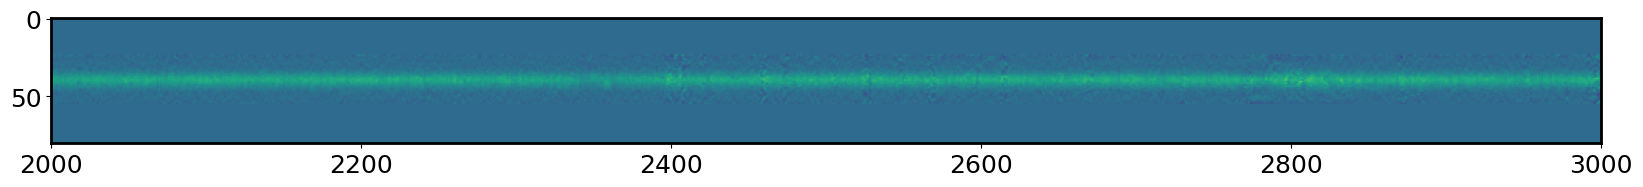

In [7]:
plt.figure(figsize=[20,20])
plt.imshow(hdu2d[0].data)
plt.xlim(2000,3000) #spec is very big, plot just a bit

## Now work with 1D spectrum
## Calibrate (in wavelength), inspect, and write in Spectrum1D object

In [8]:
hdu1d = fits.open(file1d)
hdu1dwht = fits.open(file1dwht)
hdu1d.info()

Filename: ./mos_spectroscopy/observed/legac_M1_v3.7_spec1d_130902.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     715   (6166,)   float32   


In [9]:
hdu1d[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    1 / number of data axes                            
NAXIS1  =                 6166 / length of data axis 1                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2015-01-26T12:24:07' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO     '           / European Southern Observatory                  
MJD-OBS =       57040.16930682 / Obs start 2015-01-18T04:03:48.109              
DATE-OBS= '2015-01-18T04:03:48.108' / Date of observation                       
EXPTIME =             1199.997 / Total integration time. 00:19:59.997           
TELESCOP= 'ESO-VLT-U3'      

If i want to do it in Pandas.

In [10]:
flux = hdu1d[0].data.byteswap().newbyteorder()
wht = hdu1dwht[0].data.byteswap().newbyteorder()
unc = 1./ np.sqrt(wht)
wave = np.arange(flux.shape[0])*hdu1d[0].header['CD1_1'] + hdu1d[0].header['CRVAL1']

##for certain functions, I need to cut the spectrum where the weight is 0.
d = {'wavelength':wave, 'flux':flux, 'weight':wht, 'uncertainty':unc}
dataspec = pd.DataFrame(data=d)

##define subset where wht>0
dataspec_sub = dataspec[dataspec['weight'] > 0.].reset_index(drop=True)
dataspec_sub.head()

,wavelength,flux,weight,uncertainty
0,6229.3,14.757169,0.207031,2.197769
1,6229.9,26.817886,0.148122,2.598306
2,6230.5,23.955254,0.142191,2.651945
3,6231.1,22.239902,0.141403,2.659323
4,6231.7,22.505369,0.136912,2.702580


If I want to do it in astropy Tables.

In [11]:
flux = hdu1d[0].data
wht = hdu1dwht[0].data
unc = 1./ np.sqrt(wht)
wave = np.arange(flux.shape[0])*hdu1d[0].header['CD1_1'] + hdu1d[0].header['CRVAL1']

spec_unit = u.Unit('10^-19 erg s^-1 cm^-2 angstrom^-1')
dataspec = QTable([wave*u.angstrom, flux*spec_unit, wht, unc*spec_unit], 
                   names=('wavelength','flux','weight','uncertainty'))
dataspec_sub = dataspec[dataspec['weight']>0.]
dataspec_sub

wavelength,flux,weight,uncertainty
Angstrom,1e-19 erg / (Angstrom s cm2),,1e-19 erg / (Angstrom s cm2)
float64,float32,float32,float32
6229.3,14.757168769836426,0.20703126,2.1977689266204834
6229.900000000001,26.817886352539062,0.14812198,2.5983057022094727
6230.5,23.95525360107422,0.14219064,2.651945114135742
6231.1,22.23990249633789,0.14140277,2.659322738647461
6231.7,22.505369186401367,0.13691239,2.702580213546753
6232.3,21.266435623168945,0.12861502,2.788393974304199
6232.900000000001,21.235198974609375,0.11325585,2.9714584350585938
6233.5,24.18277359008789,0.096821204,3.2137696743011475


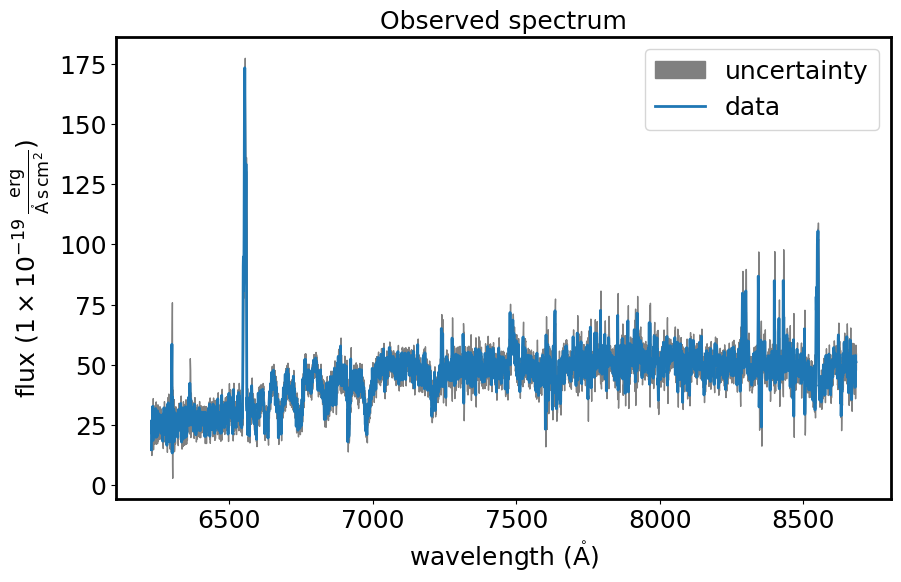

In [12]:
plt.figure(figsize=[10,6])
plt.fill_between(dataspec_sub['wavelength'],
                 dataspec_sub['flux']+dataspec_sub['uncertainty'],
                 dataspec_sub['flux']-dataspec_sub['uncertainty'],
                 color='gray',label="uncertainty")
plt.plot(dataspec_sub['wavelength'],dataspec_sub['flux'], label="data")
plt.xlabel("wavelength ({:latex})".format(dataspec_sub['wavelength'].unit))
plt.ylabel("flux ({:latex})".format(dataspec_sub['flux'].unit))
plt.title("Observed spectrum")
plt.legend()
plt.show()

## Go with specutils

In [13]:
#write Spectrum1D object
spec1d = Spectrum1D(spectral_axis=dataspec_sub['wavelength'], 
                    flux=dataspec_sub['flux'], 
                    uncertainty=StdDevUncertainty(dataspec_sub['uncertainty']))

##### Developer note

For supported datasets (like final JWST data products), this will be as simple as:
```
spec1d = Spectrum1d.read('datafile.fits')
```

##### Developer note

Implemented but not yet released: `snr_threshold`, which will allow cutting the spectrum using that function.

## Smooth to better inspect the features

##### Developer note

The uncertainty is not carried over, but would be useful. Same comment on the interactive tool as before: it would be very useful to be able to zoom, pan, hoover, etc. on the spectrum.

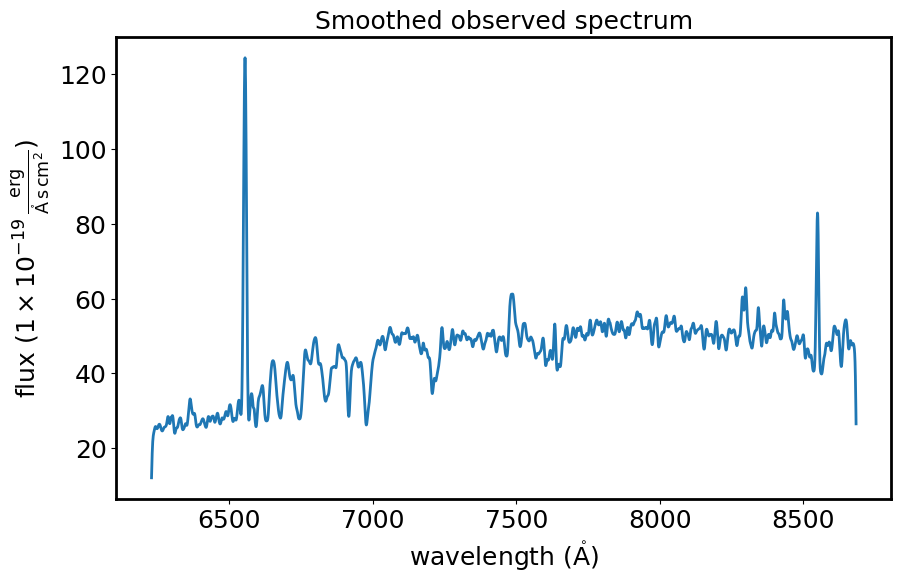

In [14]:
spec1d_gsmooth = gaussian_smooth(spec1d, stddev=5)
plt.figure(figsize=[10,6])
plt.plot(spec1d_gsmooth.spectral_axis,spec1d_gsmooth.flux)
plt.xlabel("wavelength ({:latex})".format(spec1d_gsmooth.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_gsmooth.flux.unit))
plt.title("Smoothed observed spectrum")
plt.show()

## Back to the non-smoothed spectrum to find lines

Documentation says I need a continuum subtracted spectrum.

## So fit continuum first

In [15]:
cont_spec1d = fit_generic_continuum(spec1d)
cont_fit = cont_spec1d(spec1d.spectral_axis)

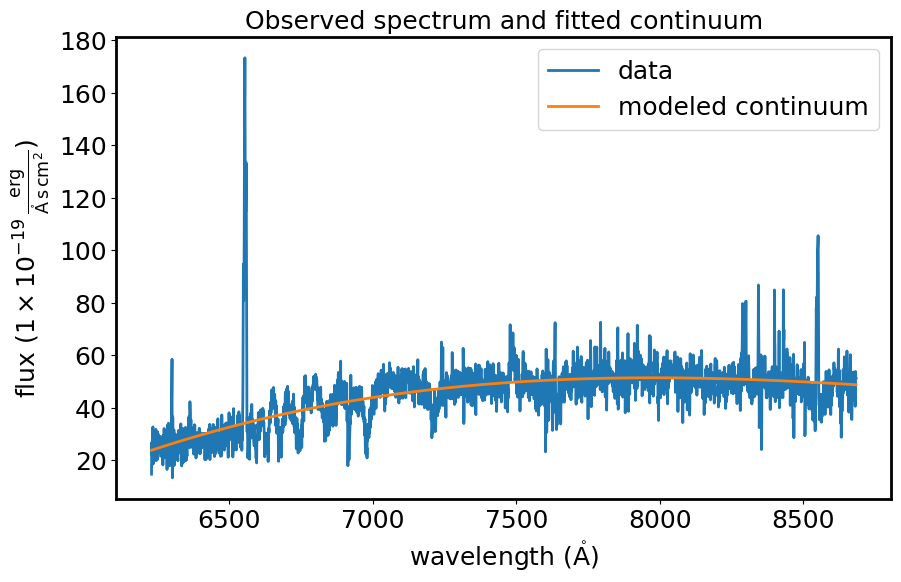

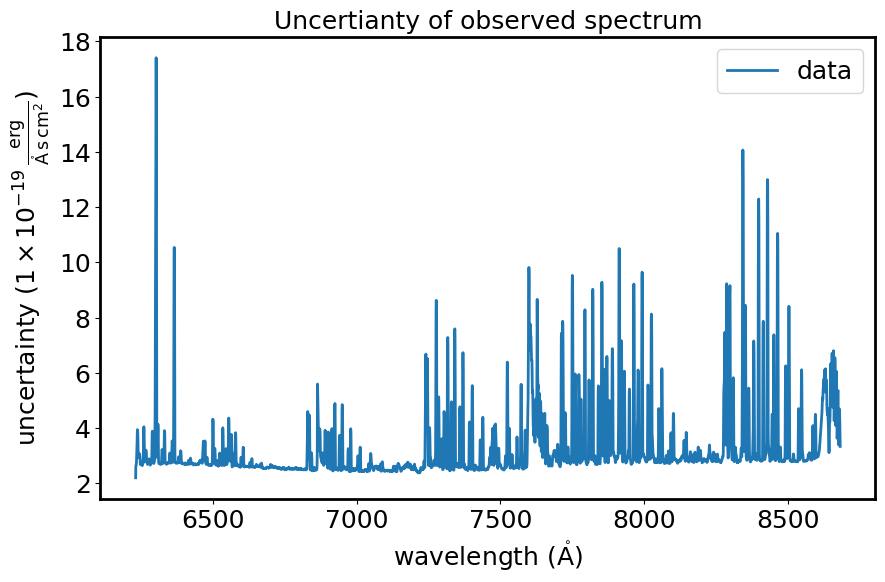

In [16]:
plt.figure(figsize=[10,6])
plt.plot(spec1d.spectral_axis, spec1d.flux, label="data")
plt.plot(spec1d.spectral_axis, cont_fit, label="modeled continuum")
plt.xlabel("wavelength ({:latex})".format(spec1d.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d.flux.unit))
plt.legend()
plt.title("Observed spectrum and fitted continuum")
plt.show()

plt.figure(figsize=[10,6])
plt.plot(spec1d.spectral_axis, spec1d.uncertainty.array, label="data")
plt.xlabel("wavelength ({:latex})".format(spec1d.spectral_axis.unit))
plt.ylabel("uncertainty ({:latex})".format(spec1d.uncertainty.unit))
plt.legend()
plt.title("Uncertianty of observed spectrum")
plt.show()

### Creating the continuum-subtracted spectrum
Specutils will figure out what to do with the uncertainty!

In [17]:
spec1d_sub = spec1d - cont_fit
spec1d_sub

<Spectrum1D(flux=<Quantity [-9.11481202,  2.92418963,  0.03985127, ...,  2.46770635,
            2.81985914,  2.41054724] 1e-19 erg / (Angstrom s cm2)>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0)
  [6229.3, 6229.9, 6230.5, ..., 8682.1, 8682.7, 8683.3] Angstrom>, uncertainty=StdDevUncertainty([2.197769 , 2.5983057, 2.651945 , ..., 4.1351385,
                   3.8055754, 3.3335283]))>

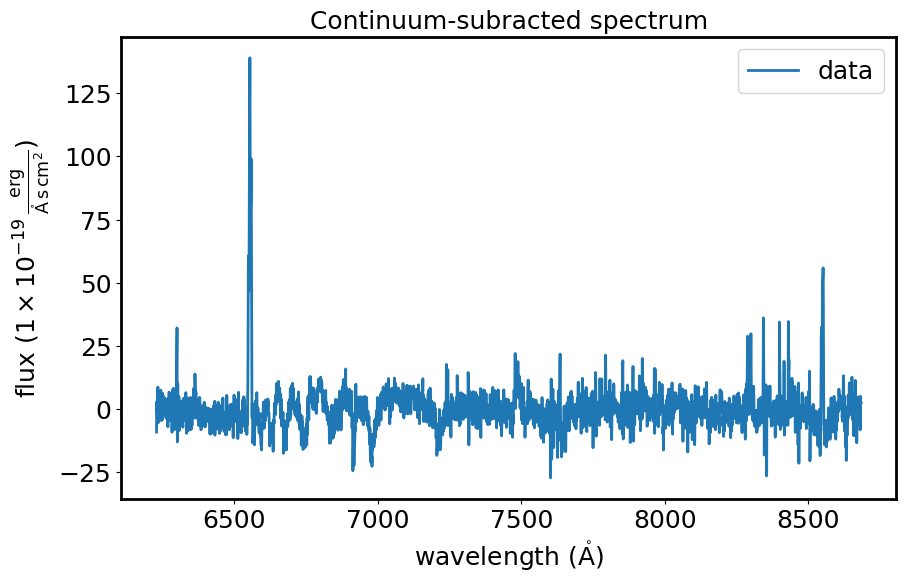

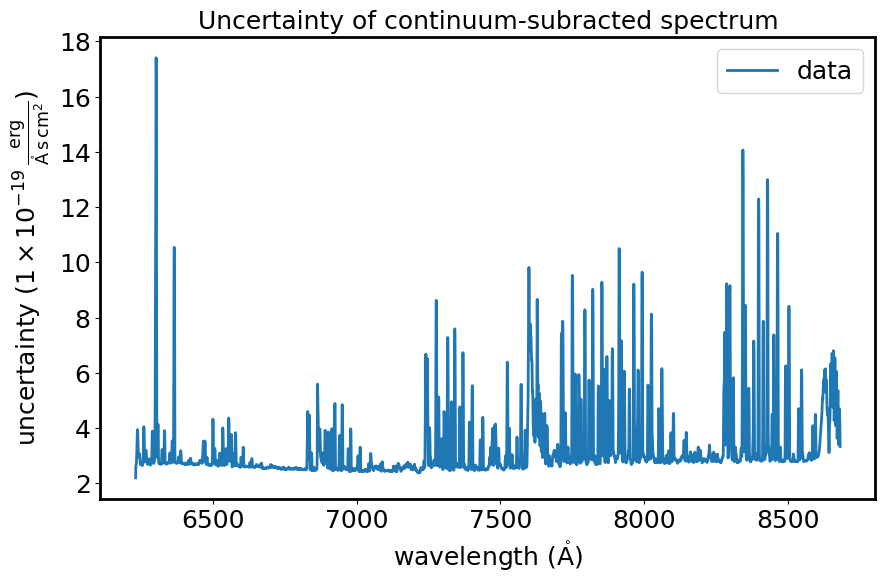

In [18]:
plt.figure(figsize=[10,6])
plt.plot(spec1d_sub.spectral_axis, spec1d_sub.flux, label="data")
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_sub.flux.unit))
plt.legend()
plt.title("Continuum-subracted spectrum")
plt.show()

plt.figure(figsize=[10,6])
plt.plot(spec1d_sub.spectral_axis,spec1d_sub.uncertainty.array, label="data")
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("uncertainty ({:latex})".format(spec1d_sub.uncertainty.unit))
plt.legend()
plt.title("Uncertainty of continuum-subracted spectrum")
plt.show()

## Now look for the lines

In [19]:
lines = find_lines_derivative(spec1d_sub, flux_threshold=50)
lines

line_center,line_type,line_center_index
Angstrom,,
float64,str8,int64
6549.1,emission,528
6553.900000000001,emission,536
6558.7,emission,544
8550.7,emission,3837


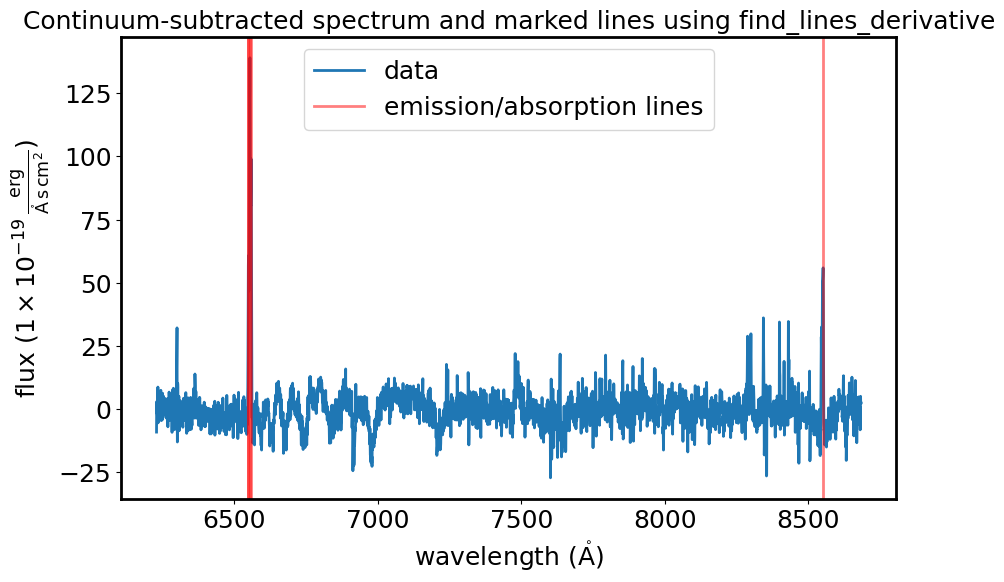

In [20]:
plt.figure(figsize=[10,6])
plt.plot(spec1d_sub.spectral_axis,spec1d_sub.flux,label="data")
plt.axvline(lines['line_center'][0].value, color="red", alpha=0.5, label='emission/absorption lines')
for line in lines:
    plt.axvline(line['line_center'].value, color='red',alpha=0.5)
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d.flux.unit))
plt.legend()
plt.title("Continuum-subtracted spectrum and marked lines using find_lines_derivative")
plt.show()

This works for cases where you understand the thresholds well, but doesn't automate as well with noisy spectra.

### Works better with find_lines_threshold

In [21]:
lines = find_lines_threshold(spec1d_sub, noise_factor=6)
lines

line_center,line_type,line_center_index
Angstrom,,
float64,str10,int64
6554.5,emission,537
7478.5,emission,2062
7488.1,emission,2072
8546.5,emission,3830
8551.3,emission,3838
6635.5,absorption,667
6671.5,absorption,727
6681.1,absorption,743


Plot lines on the spectrum.

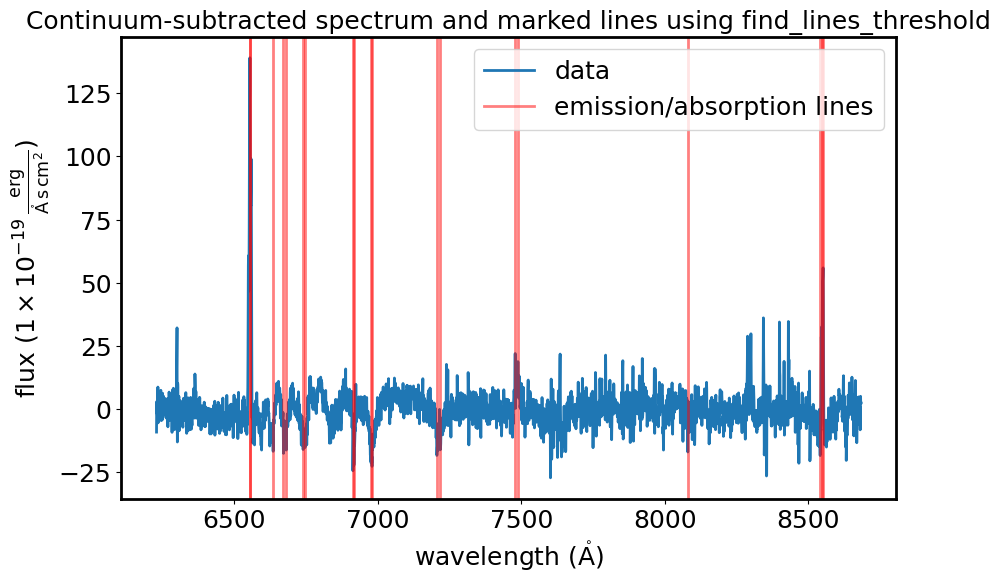

In [22]:
plt.figure(figsize=[10,6])
plt.plot(spec1d_sub.spectral_axis,spec1d_sub.flux,label="data")
plt.axvline(lines['line_center'][0].value, color="red", alpha=0.5, label='emission/absorption lines')
for line in lines:
    plt.axvline(line['line_center'].value, color='red', alpha=0.5)
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_sub.flux.unit))
plt.legend()
plt.title("Continuum-subtracted spectrum and marked lines using find_lines_threshold")
plt.show()

##### Developer note
It would be useful to have a tool to cycle through the lines, show a zoom of the spectrum, and inspect how good the line identification is. For now I do it by hand on a single line.

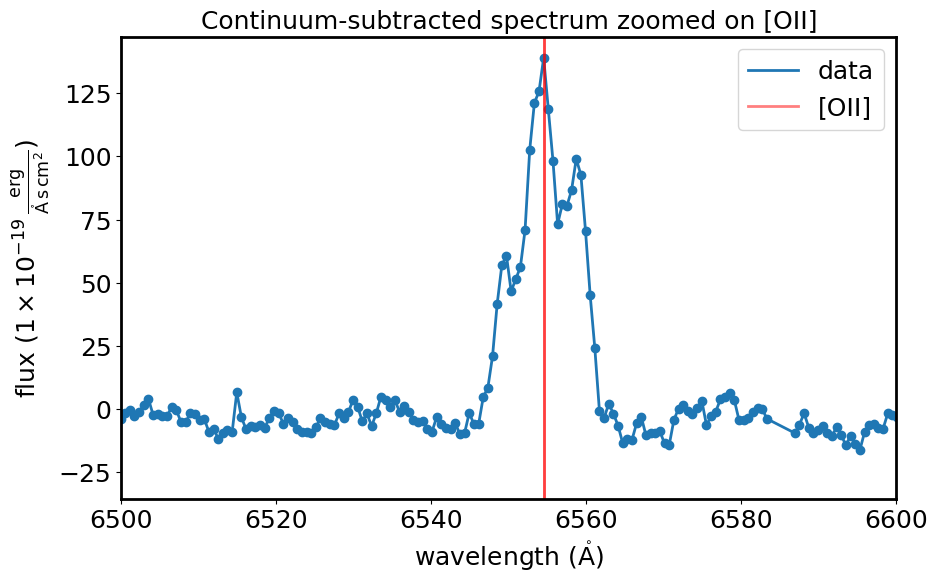

In [23]:
plt.figure(figsize=[10,6])
plt.plot(spec1d_sub.spectral_axis,spec1d_sub.flux, label="data")
plt.scatter(spec1d_sub.spectral_axis,spec1d_sub.flux, label=None)
plt.axvline(lines['line_center'][0].value, color="red", alpha=0.5, label='[OII]')
for line in lines:
    plt.axvline(line['line_center'].value, alpha=0.5, color='red')
plt.xlim(6500,6600)
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_sub.flux.unit))
plt.legend()
plt.title("Continuum-subtracted spectrum zoomed on [OII]")
plt.show()

## Measure line centroids and fluxes
These too need spectra continuum subtracted.

In [24]:
#example with just one line
centroid(spec1d_sub, SpectralRegion(6540*u.AA, 6580*u.AA))

<Quantity 6554.41499106 Angstrom>

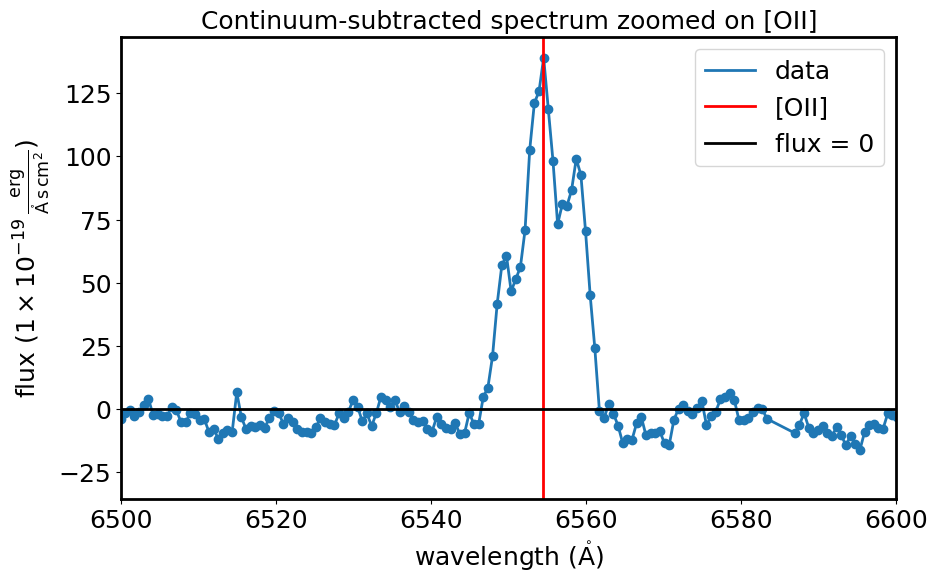

In [25]:
sline = centroid(spec1d_sub, SpectralRegion(6540*u.AA, 6580*u.AA))

plt.figure(figsize=[10,6])
plt.plot(spec1d_sub.spectral_axis,spec1d_sub.flux, label="data")
plt.scatter(spec1d_sub.spectral_axis,spec1d_sub.flux, label=None)
plt.axvline(sline.value, color='red', label="[OII]")
plt.axhline(0,color='black', label='flux = 0')
plt.xlim(6500,6600)
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_sub.flux.unit))
plt.legend()
plt.title("Continuum-subtracted spectrum zoomed on [OII]")
plt.show()

In [26]:
line_flux(spec1d_sub, SpectralRegion(6540*u.AA, 6570*u.AA))  

<Quantity 965.51743109 1e-19 erg / (s cm2)>

## Fit the line with a Gaussian

##### Developer note
Fitting lines with Gaussians is so common that it might make sense to have a one-line to iterate this over the list of lines, with sensible initialization of parameters and fit ranges for each line so that the fits generally work.

Also, the interactive tool here could allow one to select the continuum region and position of the line by clicking on the spectrum.

In [27]:
g_init = models.Gaussian1D(amplitude= 3 * 1e-19 * u.erg / u.s / u.cm**2 / u.AA, mean=6554*u.AA, stddev=2.*u.AA)
g_fit = fit_lines(spec1d_sub, g_init)
spec1d_fit = g_fit(spec1d_sub.wavelength)
g_fit

<Gaussian1D(amplitude=116.3316537 1e-19 erg / (Angstrom s cm2), mean=6554.93917566 Angstrom, stddev=3.71890257 Angstrom)>

In [28]:
#calculate the velocity dispertion from the stddev
vel = ((3.71890256/6554.415) * const.c.to('km/s').value)*u.km/u.s
print(vel)

170.0989240877931 km / s


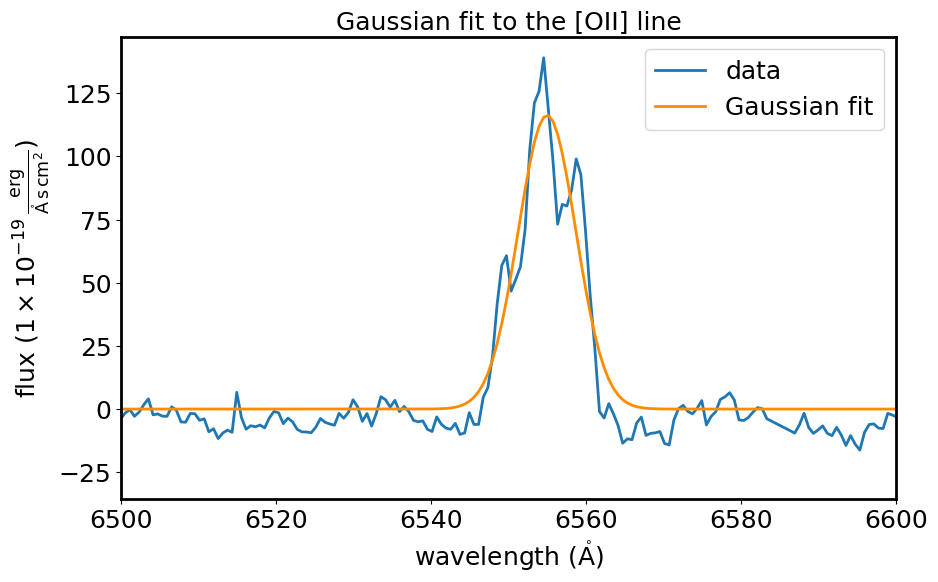

In [29]:
plt.figure(figsize=[10,6])
plt.plot(spec1d_sub.wavelength,spec1d_sub.flux,label='data')
plt.plot(spec1d_sub.wavelength,spec1d_fit,color='darkorange',label='Gaussian fit')
plt.xlim(6500,6600)
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_sub.flux.unit))
plt.legend()
plt.title('Gaussian fit to the [OII] line')
plt.show()

## Measure the equivalent width of the lines
This needs the spectrum continuum normalized.

In [30]:
spec1d_norm = spec1d / cont_fit

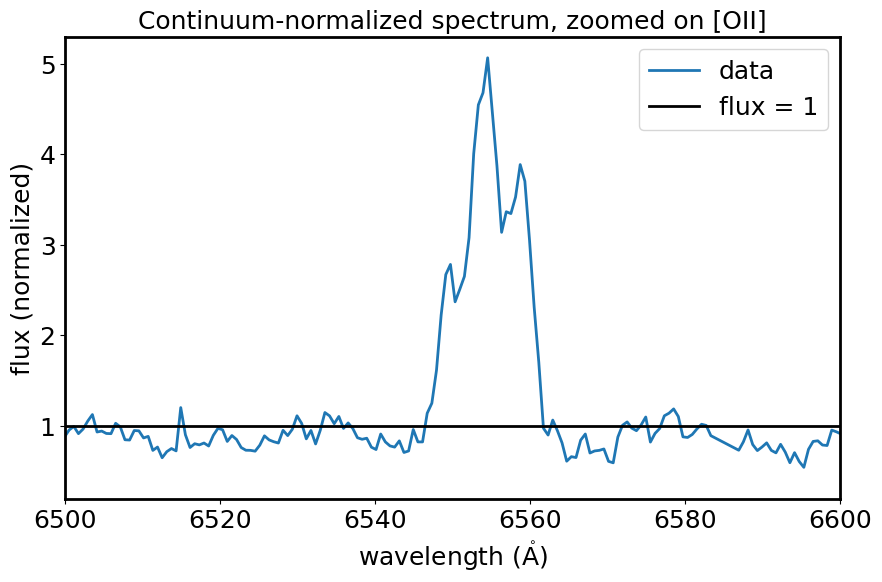

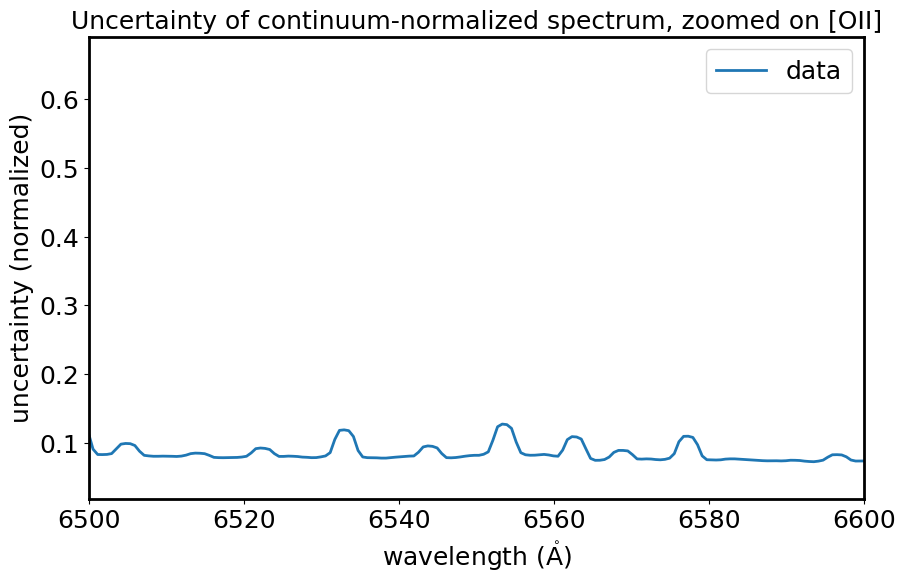

In [31]:
plt.figure(figsize=[10,6])
plt.plot(spec1d_norm.spectral_axis, spec1d_norm.flux, label='data')
plt.axhline(1,color='black',label='flux = 1')
plt.xlabel("wavelength ({:latex})".format(spec1d_norm.spectral_axis.unit))
plt.ylabel("flux (normalized)")
plt.xlim(6500,6600)
plt.legend()
plt.title("Continuum-normalized spectrum, zoomed on [OII]")
plt.show()

plt.figure(figsize=[10,6])
plt.plot(spec1d_norm.spectral_axis, spec1d_norm.uncertainty.array, label='data')
plt.xlabel("wavelength ({:latex})".format(spec1d_norm.spectral_axis.unit))
plt.ylabel("uncertainty (normalized)")
plt.xlim(6500,6600)
plt.legend()
plt.title("Uncertainty of continuum-normalized spectrum, zoomed on [OII]")
plt.show()

In [32]:
equivalent_width(spec1d_norm, regions=SpectralRegion(6540*u.AA, 6570*u.AA))

<Quantity -28.24394831 Angstrom>

## Find the best-fitting template
It needs a list of templates and the redshift of the observed galaxy. For the templates, I am using a set of model SEDs generated with Bruzual & Charlot stellar population models, emission lines, and dust attenuation as described in Pacifici et al. (2012).

##### Developer note
Maybe there is a way to speed this up (maybe using astropy model_sets)? This fit is run with 100 models, but ideally, if we want to extract physical parameters from this, we would need at least 10,000 models.

A dictionary structure with meaningful keys (which can be, e.g., tuples of the relevant physical parameters) could be better than a list? It could make later analysis much clearer than having to map from the list indices back to the relevant parameters.

In [33]:
templatedir = './mos_spectroscopy/templates/'

In [34]:
zz = 0.758

templatelist = []
for i in range (1, 101):
    template_file = "{0}{1:05d}.dat".format(templatedir,i)
    template = ascii.read(template_file)
    temp1d = Spectrum1D(spectral_axis=template['col1']*u.AA,flux=template['col2']*u.erg/u.s/u.AA)
    templatelist.append(temp1d)
    
    
tm_results = template_comparison.template_match(observed_spectrum=spec1d, spectral_templates=templatelist, resample_method="flux_conserving", redshift=zz)

In [35]:
tm_results[0]

<Spectrum1D(flux=<Quantity [0.        , 0.        , 0.        , ..., 0.09480264, 0.09410727,
           0.09341189] 1e-19 erg / (Angstrom s cm2)>, spectral_axis=<SpectralAxis [   177.0306,    178.6128,    180.195 , ..., 170526.    , 171229.2   ,
   171932.4   ] Angstrom>)>

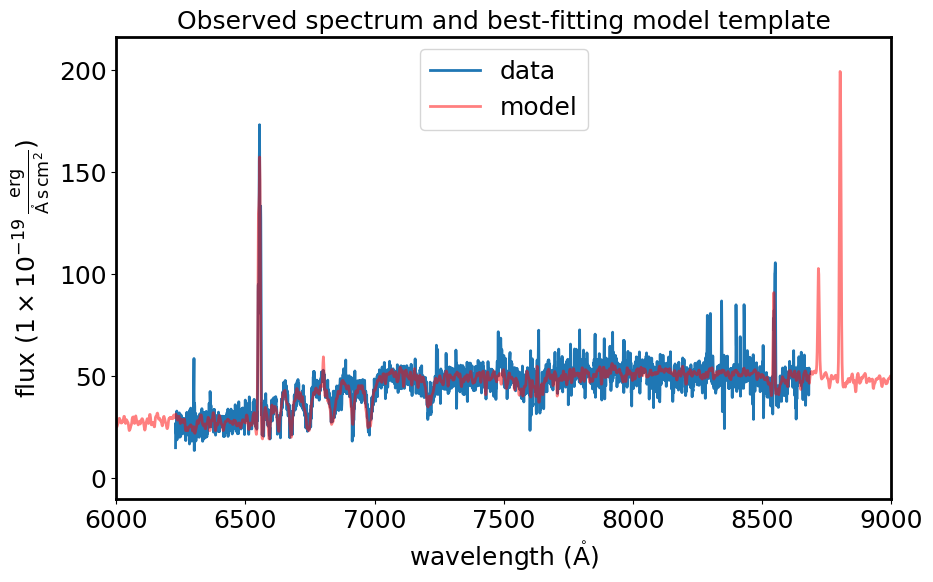

In [36]:
plt.figure(figsize=[10, 6])
plt.plot(spec1d.wavelength, spec1d.flux, label="data")
plt.plot(tm_results[0].wavelength, tm_results[0].flux,color='r',alpha=0.5,label='model')
plt.xlim(6000, 9000)
plt.xlabel("wavelength ({:latex})".format(spec1d_norm.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_sub.flux.unit))
plt.legend()
plt.title("Observed spectrum and best-fitting model template")
plt.show()

## Potential next steps:
    - Automatic template *fitting* to get the redshift
    - Measure if emission-line profile is consistent with PSF
    - Measure line intensities in 2D
    - Convert distances from pixels to kpc
    - Run the line measurements on a set of lines
    - Run the whole procedure on all galaxies detected on a mask